# Annotate paintings
This notebook leverages an LLM to extract the described objects that appear in a painting and then ground them with Grounding DINO.

### 0. Import libraries and set the configuration

In [1]:
import io
import os
import copy
import json
import time
import random

import torch
import numpy as np
import polars as pl
from tqdm import tqdm
from PIL import Image
from google import genai
from google.genai import types
from nltk.corpus import stopwords
from PIL import Image, ImageDraw, ImageFont
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

In [2]:
GEMINI_MODEL = "gemini-2.0-flash"
GROUNDING_MODEL_ID = "IDEA-Research/grounding-dino-base"

RAW_DATA_PATH = "../../data/raw/"
ANNOTATIONS_PATH = "../../data/annotations/"
RESULTS_PATH = "../../experiments/prompting/"
INTERMEDIATE_DATA_PATH = "../../data/intermediate/filtered_paintings/"

FEW_SHOT_EXAMPLES_IDS = [2156, 2484, 11819, 256, 10748, 3344, 10676]

SEED = 42
STOP_WORDS = stopwords.words("english")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True, warn_only=True)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"


In [3]:
with open("../../config/keys.json", "r") as file:
    os.environ["GEMINI_API_KEY"] = json.load(file)["gemini_api_key"]

### 1. Extract with an LLM the described objects

#### 1.1. Define auxiliary functions

In [4]:
def show_available_models(client):
    existing_models = [
        model.name.split("/")[1]
        for model in client.models.list()
        if "generateContent" in model.supported_actions
    ]

    print(existing_models)

In [5]:
def image_to_bytes(image):
    # define an in-memory byte stream
    img_byte_array = io.BytesIO()

    # convert the image to a byte representation and store it in the in-memory byte stream
    image.save(img_byte_array, format="PNG")

    # get the byte representation of the image
    img_bytes = img_byte_array.getvalue()

    return img_bytes

#### 1.2. Define prompts to experiment with

In [6]:
def get_basic_prompt(examples, image, description):
    prompt_parts = []
    prompt_parts.append(types.Content(role="user", parts=[types.Part.from_text(text="\nHere are some examples:")]))

    for example in examples:
        example_painting_id = example["painting_id"]
        example_description = example["description"]
        example_detected_objects = ", ".join(example["object_name"])
        example_image = Image.open(f"{RAW_DATA_PATH}filtered_paintings/{example_painting_id}.png")

        prompt_parts.append(types.Content(role="user", parts=[
            types.Part.from_bytes(mime_type="image/png", data=image_to_bytes(example_image)),
            types.Part.from_text(text=f"Description: \"\"\"{example_description}\"\"\"")
        ]))
        prompt_parts.append(types.Content(role="model", parts=[
            types.Part.from_text(text=f"Detected objects: {example_detected_objects}")
        ]))
        prompt_parts.append(types.Content(role="user", parts=[types.Part.from_text(text="---")]))

    prompt_parts.append(types.Content(role="user", parts=[
        types.Part.from_bytes(mime_type="image/png", data=image_to_bytes(image)),
        types.Part.from_text(text=f"Description: \"\"\"{description}\"\"\"\n\nList separated by comma of **ONLY** the objects (lowercased) described in the given painting that also appear in the textual description.")
    ]))


    system_prompt_text = """You are an expert in art who can identify objects present in both a painting and its textual description."""

    return prompt_parts, system_prompt_text


In [7]:
def get_prompt(examples, image, description):
    if PROMPT_TYPE == "basic":
        return get_basic_prompt(examples, image, description)
    else:
        raise "Unknown prompt type"


#### 1.3. Call the LLM to annotate the painting

In [8]:
def generate(client, examples, image, description):
    prompt_parts, system_prompt_text = get_prompt(examples, image, description)

    generate_content_config = types.GenerateContentConfig(
        temperature=0.0,
        response_mime_type="text/plain",
        system_instruction=[
            types.Part.from_text(text=system_prompt_text),
        ],
    )
    
    response = client.models.generate_content(
        model=GEMINI_MODEL,
        contents=prompt_parts,
        config=generate_content_config,
    )

    output = response.text
    prompt_tokens_count = response.usage_metadata.prompt_token_count
    output_tokens_count = response.usage_metadata.candidates_token_count
    total_token_count = prompt_tokens_count + output_tokens_count

    if VERBOSE:
        print(f"Prompt tokens count: {prompt_tokens_count}\nOutput tokens count: {output_tokens_count}")
        print(f"Response:\n{output}\n")

    return output, total_token_count

### 2. Ground Objects with Grounding DINO

In [9]:
def display_annotated_image(image, labels_scores_boxes):
    font = ImageFont.truetype("../../config/alata-regular.ttf", 18)
    draw = ImageDraw.Draw(image, "RGBA")

    for label, score, coords in labels_scores_boxes:
        random_color = "#{:06x}".format(random.randint(0, 0xFFFFFF)) + "80"
        text_position = (coords[0] + 10, coords[1] + 5)

        draw.rectangle(coords, outline=random_color, width=5)
        draw.text(text_position, label + " " + str(round(score, 2)), fill=random_color, font=font)

    display(image)

In [10]:
def detect_objects(image, text, processor, model, object_threshold=0.3, text_threshold=0.3):
    inputs = processor(images=image, text=text, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        outputs = model(**inputs)

    results = processor.post_process_grounded_object_detection(
        outputs,
        inputs.input_ids,
        # threshold for filtering object detection predictions (lower -> more bounding boxes)
        threshold=object_threshold,
        # threshold for filtering text detection predictions (lower -> the input text is taken exactly)
        text_threshold=text_threshold,
        target_sizes=[image.size[::-1]],
    )

    assert len(results) == 1

    labels = results[0]["text_labels"]
    scores = results[0]["scores"].cpu().numpy()
    box_coordinates = [list(coords) for coords in results[0]["boxes"].cpu().numpy()]
    labels_scores_boxes = sorted(list(zip(labels, scores, box_coordinates)), key=lambda x: x[1])

    if VERBOSE:
        for label, score, coords in labels_scores_boxes:
            print(label, float(score), [float(coord) for coord in coords])

    display_annotated_image(image, labels_scores_boxes)

    return labels_scores_boxes

### 3. Annotate painting

#### 3.1. Define auxiliary functions

In [11]:
def load_data():
    paintings_data = pl.read_json(f"{INTERMEDIATE_DATA_PATH}filtered_paintings_enhanced_data.json")
    annotations = pl.read_json(ANNOTATIONS_PATH + "manual_annotations.json").with_columns(pl.col("object_name").str.replace_all(',','',literal=True).alias("object_name"))
   
    few_shots_descriptions = paintings_data.filter(pl.col("id").is_in(FEW_SHOT_EXAMPLES_IDS)).select("id", "description").rename({"id": "painting_id"})
    few_shot_examples = ((
        annotations.filter(pl.col("painting_id").is_in(FEW_SHOT_EXAMPLES_IDS))
        .group_by("painting_id")
        .agg(pl.col("*"))
        .select("painting_id", "object_name", "description_spans")
    ).join(few_shots_descriptions, on="painting_id")).to_dicts()

    test_descriptions = paintings_data.filter(~pl.col("id").is_in(FEW_SHOT_EXAMPLES_IDS)).select("id", "description").rename({"id": "painting_id"})
    test_paintings = ((annotations.filter(~pl.col("painting_id").is_in(FEW_SHOT_EXAMPLES_IDS))
        .group_by("painting_id")
        .agg(pl.col("*"))
        .select("painting_id", "object_name", "description_spans")
    ).join(test_descriptions, on="painting_id")).to_dicts()

    return paintings_data, annotations, few_shot_examples, test_paintings

In [12]:
def clean_object_name(object_name):
    input_words = object_name.lower().split(" ")
    cleaned_object_name = " ".join([word.replace("\n", "") for word in input_words if word.replace("\n", "") not in STOP_WORDS])

    return cleaned_object_name

In [13]:
def compute_f1(predictions, ground_truth, tp_fp_fn):
    for prediction in predictions:
        if prediction in ground_truth:
            tp_fp_fn[0] += 1
            ground_truth.remove(prediction)
        else:
            tp_fp_fn[1] += 1

    tp_fp_fn[2] = len(ground_truth)

In [14]:
def compute_micro_f1(tp_fp_fn):
    if tp_fp_fn[0] + tp_fp_fn[1] == 0:
        precision = 0
    else:
        precision = tp_fp_fn[0] / (tp_fp_fn[0] + tp_fp_fn[1])

    if tp_fp_fn[0] + tp_fp_fn[2] == 0:
        recall = 0
    else:
        recall = tp_fp_fn[0] / (tp_fp_fn[0] + tp_fp_fn[2])

    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)

    return round(f1, 2)

In [15]:
def store_results(micro_f1, results_values):
    results_file_name = f"{RESULTS_PATH}prompting_results.json"

    try:
        with open(results_file_name, "r") as file:
            all_results = json.load(file)
    except:
            all_results = None

    results = {"prompt_type": PROMPT_TYPE,
    "observations": OBSERVATIONS,
    "micro_f1": micro_f1,
    "results": results_values}

    if all_results is None:
        all_results = [results]
    else:
        all_results.append(results)

    with open(results_file_name, "w") as file:
        json.dump(all_results, file, indent=4)

#### 3.2. Experiment with a prompt

In [16]:
VERBOSE = True
PROMPT_TYPE = "basic"
OBSERVATIONS = "first trial with few-shot learning"

In [17]:
# define LLM client
client = genai.Client(api_key=os.environ.get("GEMINI_API_KEY"))

# load Grounding DINO
processor = AutoProcessor.from_pretrained(GROUNDING_MODEL_ID)
model = AutoModelForZeroShotObjectDetection.from_pretrained(GROUNDING_MODEL_ID).to(DEVICE)

# load data
paintings_data, annotations, few_shot_examples, test_paintings = load_data()

  0%|          | 0/2 [00:00<?, ?it/s]

Prompt tokens count: 5346
Output tokens count: 3
Response:
breton costumes

['breton costumes'] ['breton costumes']
breton costumes 0.3429620563983917 [154.9503936767578, 229.47482299804688, 517.6773681640625, 969.2733764648438]
breton costumes 0.8039714694023132 [140.8706817626953, 140.79884338378906, 635.9989624023438, 1153.1868896484375]


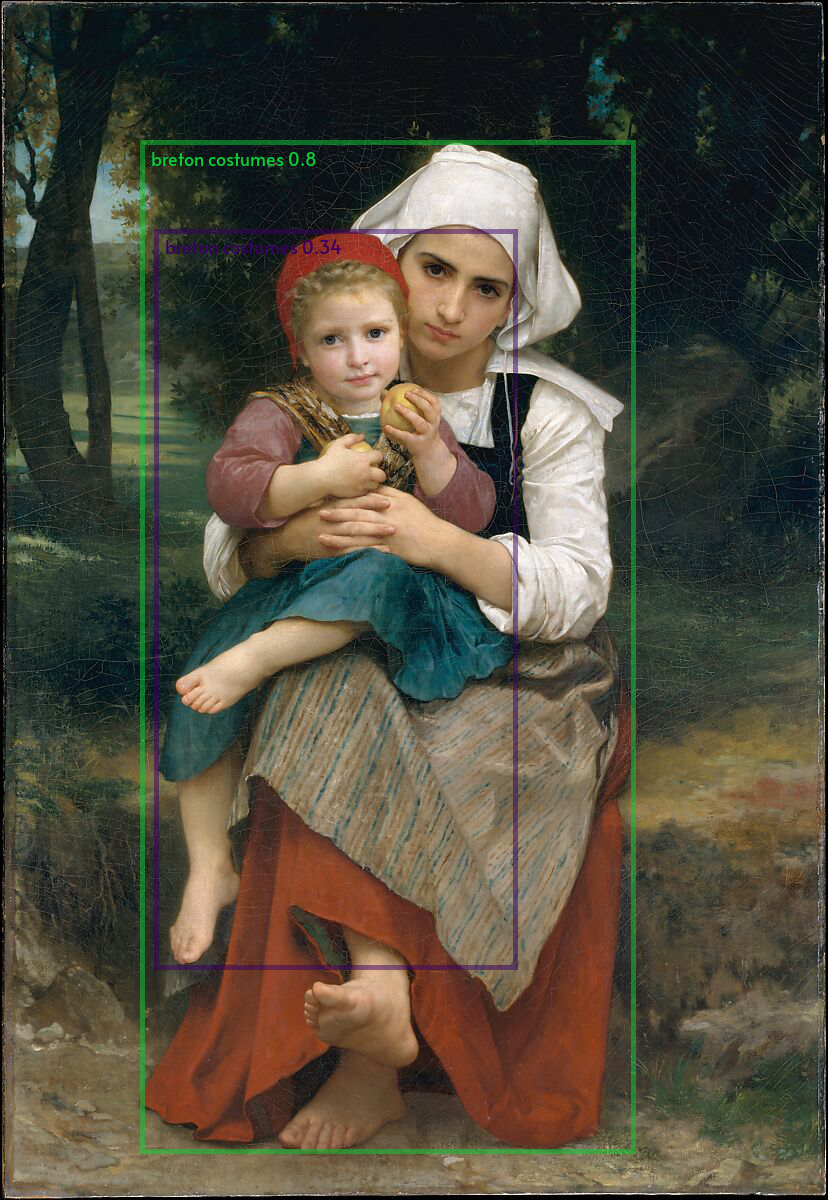

 50%|█████     | 1/2 [00:11<00:11, 11.35s/it]

Prompt tokens count: 5311
Output tokens count: 5
Response:
self-portraits, mirror

['mirror', 'self-portraits'] ['']


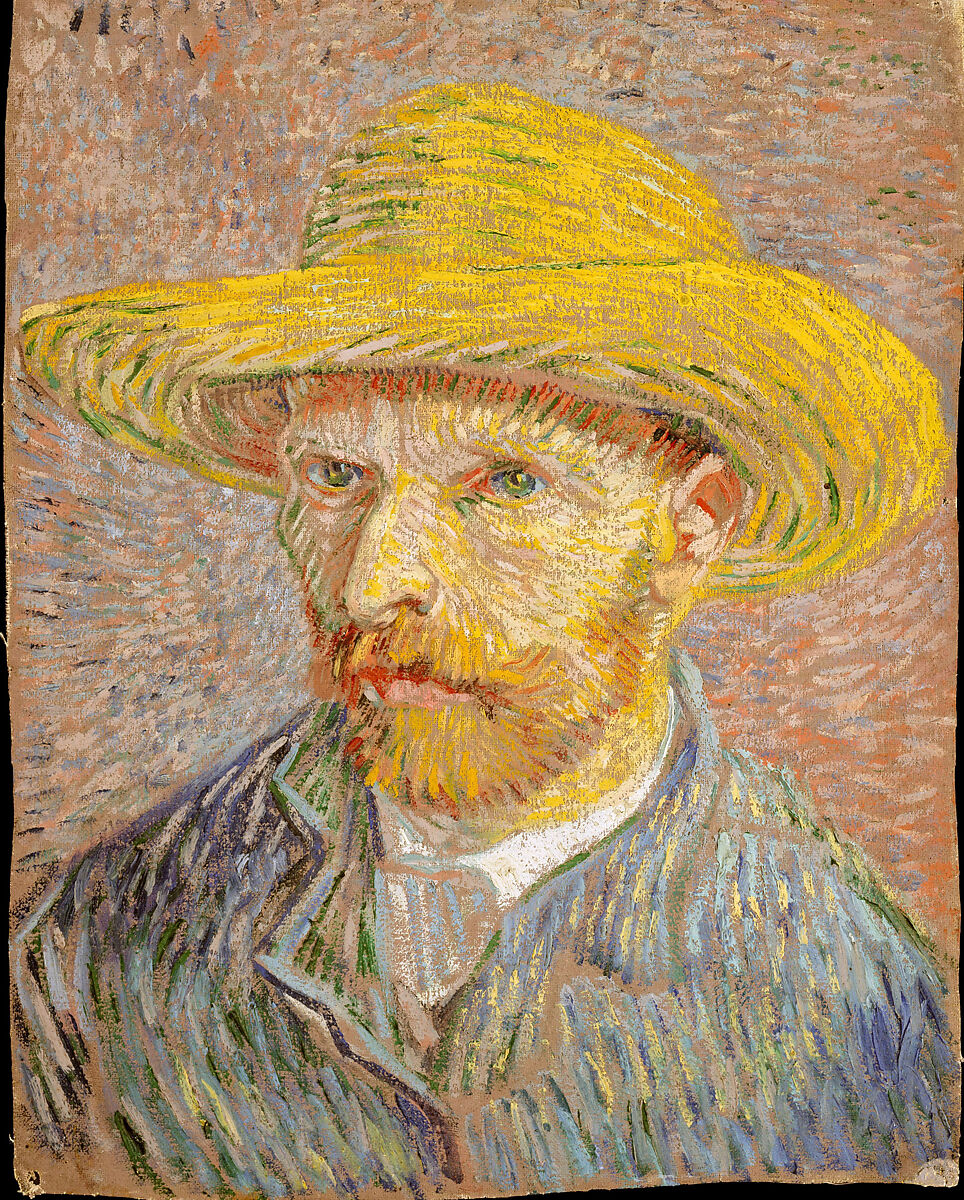

100%|██████████| 2/2 [00:21<00:00, 10.68s/it]

Micro F1: 0.4
Total token count: 10665


In [18]:
tp_fp_fn = [0, 0, 0]
total_token_count = 0

painting_ids = []
all_predicted_objects = []
all_ground_truth_objects = []

for painting in tqdm(test_paintings[:2]):
    painting_id = painting["painting_id"]
    painting_ids.append(painting_id)
    ground_truth_objects = copy.deepcopy(painting["object_name"])
    description = copy.deepcopy(painting["description"])
    image = Image.open(f"{RAW_DATA_PATH}filtered_paintings/{painting_id}.png")

    # extract described objects
    output, token_count = generate(client, few_shot_examples, image, description)
    total_token_count += token_count

    # compute metrics
    predicted_objects = sorted([clean_object_name(object_name) for object_name in output.split(", ")])
    all_predicted_objects.append(predicted_objects)
    ground_truth_objects = sorted([clean_object_name(object_name) for object_name in ground_truth_objects])
    all_ground_truth_objects.append(ground_truth_objects)
    
    if VERBOSE:
        print(predicted_objects, ground_truth_objects)
        
    compute_f1(copy.deepcopy(predicted_objects), copy.deepcopy(ground_truth_objects), tp_fp_fn)

    # ground objects
    text = ", ".join(ground_truth_objects) + "."
    labels_scores_boxes = detect_objects(image, text, processor, model, object_threshold=0.3, text_threshold=0.3)
    
micro_f1 = compute_micro_f1(tp_fp_fn)
print(f"Micro F1: {micro_f1}")
print(f"Total token count: {total_token_count}")


In [19]:
# store results for the tested prompt
results_values = list(zip(painting_ids, all_predicted_objects, all_ground_truth_objects))
store_results(micro_f1, results_values)

In [20]:
def get_bbox_annotation():
    with open(f"{ANNOTATIONS_PATH}bounding_boxes_annotations.json", "r") as file:
        bounding_boxes_annotations = json.load(file)

    labels_mapping = {label["id"]: label["name"] for label in bounding_boxes_annotations["categories"]}
    painting_id_mapping = {painting_info["id"]: painting_info["file_name"].split("-")[-1].split(".")[0] for painting_info in bounding_boxes_annotations["images"]}


    processed_bounding_box_annotations = []


    for bounding_box_annotation in bounding_boxes_annotations["annotations"]:
        x1, y1, x2, y2 = bounding_box_annotation["bbox"]

        x2 += x1
        y2 += y1

        bbox = [x1, y1, x2, y2]

        processed_bounding_box_annotations.append({"image_id": painting_id_mapping[bounding_box_annotation["image_id"]], "label": labels_mapping[bounding_box_annotation["category_id"]], "bbox": bbox})

    return processed_bounding_box_annotations

In [ ]:
# if an image is not included, it doesn't have annotations
ground_truth_bboxes = get_bbox_annotation()

In [ ]:


for ground_truth_bboxes_ in ground_truth_bboxes:
    image_id = ground_truth_bboxes_["image_id"]
    image = Image.open(f"{RAW_DATA_PATH}filtered_paintings/{image_id}.png")

    font = ImageFont.truetype("../../config/alata-regular.ttf", 18)
    draw = ImageDraw.Draw(image, "RGBA")

    x1, y1, x2, y2 = ground_truth_bboxes_["bbox"]
    label = ground_truth_bboxes_["label"]

    random_color = "#{:06x}".format(random.randint(0, 0xFFFFFF)) + "80"
    text_position = (x1 + 10, y1 + 5)

    try:
        draw.rectangle([x1, y1, x2, y2], outline=random_color, width=5)
        draw.text(text_position, label + " " + str(round(0, 2)), fill=random_color, font=font)
    except:
        print(label, [x1, y1, x2, y2])
        pass

    display(image)